In [812]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

In [813]:
# !pip3 install torch torchvision torchaudio

# !pip install -r /Users/gleb/Desktop/DL_HSE/DL_HSE_FIRST_HW/requirements.txt

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [814]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [815]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [816]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [817]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

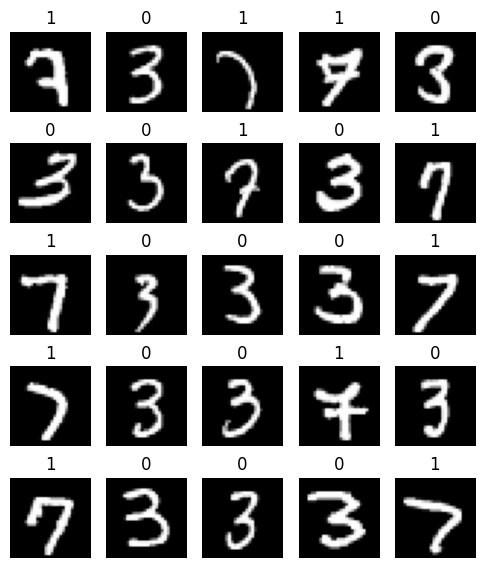

In [818]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [819]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [820]:
x.shape

torch.Size([128, 1, 28, 28])

In [821]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [822]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [823]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [824]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [825]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [826]:
y

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1])

# Итерация по эпохам

In [827]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):

    dataset_passed_samples = 0

    for x, y in train_loader:

        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация

        time.sleep(0.01)

        dataset_passed_samples += x.shape[0]

        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]

        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')

    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [828]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.45361843, 0.89442948, 0.23125716, ..., 0.63476033, 0.83163469,
        0.75739136],
       [0.8541721 , 0.95084241, 0.84352869, ..., 0.17459022, 0.53431846,
        0.80763669],
       [0.69699228, 0.25236468, 0.160445  , ..., 0.74768087, 0.19164796,
        0.77568138],
       ...,
       [0.53381442, 0.63070724, 0.33711737, ..., 0.66256446, 0.6497146 ,
        0.10010696],
       [0.13519979, 0.75444979, 0.41797411, ..., 0.41812771, 0.87871804,
        0.23057881],
       [0.22744737, 0.22915817, 0.75402545, ..., 0.15226739, 0.70205246,
        0.52630001]])

In [829]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы
x ** 2 + np.log(x)

array([[-0.58472922,  0.68843487, -1.41074509, ..., -0.0515871 ,
         0.50725426,  0.29576649],
       [ 0.57198739,  0.85369435,  0.5413793 , ..., -1.71483191,
        -0.34126705,  0.43863406],
       [ 0.12481729, -1.31319215, -1.8040615 , ...,  0.26824764,
        -1.61536621,  0.34766816],
       ...,
       [-0.34274919, -0.06312185, -0.97367599, ...,  0.02735423,
        -0.00909304, -2.29149461],
       [-1.98272267,  0.28742793, -0.69763342, ..., -0.69713757,
         0.64285418, -1.413996  ],
       [-1.42910412, -1.42082935,  0.28622521, ..., -1.85893183,
         0.13913052, -0.36489215]])

In [830]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [831]:
res

array([[132.99008917, 135.25713218, 139.89747963, ..., 129.32023658,
        133.31378132, 136.73866959],
       [120.86402832, 121.81301448, 130.67696485, ..., 120.10614499,
        122.34798869, 124.49639285],
       [128.33895975, 127.85033088, 133.72213711, ..., 125.49729199,
        128.68358077, 130.11216292],
       ...,
       [124.12964556, 125.26584213, 133.12875281, ..., 124.28171328,
        122.2246957 , 125.99782362],
       [128.24459689, 128.54956842, 136.34423409, ..., 127.72417879,
        127.49391442, 130.78531956],
       [120.82764195, 123.43559236, 134.42597856, ..., 125.86507442,
        124.0868613 , 123.12826179]])

In [832]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [833]:
from our_library import layers, wrapper, tools

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Пример c сигмоидой
В `our_library.layers` также это есть

In [834]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

# Тестирование

In [835]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [836]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [837]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [838]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

# Линейный слой

In [839]:
class Linear:
    def __init__(self, in_features, out_features):
        # инициализация весов и смещения
        self.weight = np.random.randn(in_features, out_features) * np.sqrt(2 / in_features)
        self.bias = np.zeros((1, out_features))

        # сохраняем градиент для весов и смещений
        self._grad_weight = None
        self._grad_bias = None

        # тут для обратного прохода сохраняем входные данные
        self._x = None

    def forward(self, x):
        # тоже сохраняем вход для обратного прохода
        self._x = x
        return np.dot(x, self.weight) + self.bias

    def backward(self, grad):
        # вычисляем градиент для весов и смещений
        self._grad_weight = np.dot(self._x.T, grad)
        self._grad_bias = np.sum(grad, axis=0, keepdims=True)

        return np.dot(grad, self.weight.T)

    def step(self, learning_rate):
        # обновляем веса и смещения
        self.weight -= learning_rate * self._grad_weight
        self.bias -= learning_rate * self._grad_bias

# Тестирование

In [840]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [841]:
linear = Linear(in_features=4, out_features=3)

In [842]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [843]:
forward = linear.forward(x)
backward = linear.backward(previous_grad)

In [844]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [845]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

In [846]:
# значения должны быть близкими
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [847]:
# значения должны быть близкими
assert np.allclose(linear._grad_bias, correct_grad_bias)

In [848]:
linear._grad_weight

array([[0.60719574, 0.92790321, 1.24830165],
       [0.08968325, 0.15020214, 0.19972094],
       [0.22889674, 0.71103859, 0.89213814],
       [0.14874632, 0.54024567, 0.67098608]])

In [849]:
correct_grad_bias

array([0.74640812, 1.03436018, 1.41047011])

# ReLU

In [850]:
class ReLU:
    def __init__(self):
        # храним входные данные для обратного прохода
        self._x = None

    def forward(self, x):
        # храним вход и применяем функцию активации (ReLU)
        self._x = x
        return np.maximum(0, x)

    def backward(self, prev_grad):
        # считаем градиент лосса
        return prev_grad * (self._x > 0)

    def step(self, learning_rate):
        pass

# Тестирование

In [851]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [852]:
relu = ReLU()

In [853]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [854]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [855]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test


### Не забудьте добавить np.expand_dims(y, 1) в forward

In [856]:
class BCELoss:
    def __init__(self):
        # также храним данные
        self._x = None
        self._y = None

    def forward(self, x, y):
        self._y = np.expand_dims(y, 1)
        self._x = x

        # считаем BCE loss
        eps = 1e-15
        loss = -(self._y * np.log(self._x + eps) + (1 - self._y) * np.log(1 - self._x + eps))
        return np.mean(loss)

    def backward(self):
        # считаем градиент лосса
        eps = 1e-15
        grad = -(self._y / (self._x + eps) - (1 - self._y) / (1 - self._x + eps))
        return grad / len(self._x)

    def step(self, learning_rate):
        pass

# Тестирование

In [857]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [858]:
loss = BCELoss()

In [859]:
forward = loss.forward(x, y)
backward = loss.backward()

In [860]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [861]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [862]:
class NeuralNetwork:
    def __init__(self, modules):
        # список слоев
        self.modules = modules

    def forward(self, x):
        for mod in self.modules:
            x = mod.forward(x)
        return x

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for mod in reversed(self.modules):
            grad = mod.backward(grad)

    def step(self, learning_rate):
        for mod in self.modules:
            mod.step(learning_rate)

## Реализуйте обертку над моделью

In [863]:
class MNISTWrapper(wrapper.Wrapper):
    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        # КОД ЗДЕСЬ
        # forward
        pred = self.model.forward(x)

        # loss
        loss_batch = self.loss.forward(pred, y)

        # backward от loss
        # grad = self.loss.backward(pred, y)  
        grad = self.loss.backward()  

        # backward model
        self.model.backward(grad)

        # обновление весов
        self.model.step(self.learning_rate)

        return loss_batch, pred
    
    def predict_batch(self, x):
        """
        Предсказание (aka inference) вашей модели:
        1. Рассчет forward
        :param x: входные данные np.array with shape (batch_size, n_features)
        :return: prediction - матрица предсказаний вашей модели
        """
        return self.model.forward(x)


In [864]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 10

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([Linear(in_features=784,
                                              out_features=128),
                                       ReLU(),
                                       Linear(in_features=128,
                                              out_features=10)])

loss = BCELoss()

In [865]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)



## Обучение модели

Почему то вылезает ошибка на трейне, с которой не могу разобраться, хотя тесты все проходит

In [866]:
classifier.train(train_loader, test_loader, epochs=epochs)



/var/folders/7n/rydsv3td2bb5j7n_24qcf5qc0000gn/T/ipykernel_70838/4003877387.py:13: RuntimeWarning: invalid value encountered in log
  loss = -(self._y * np.log(self._x + eps) + (1 - self._y) * np.log(1 - self._x + eps))


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

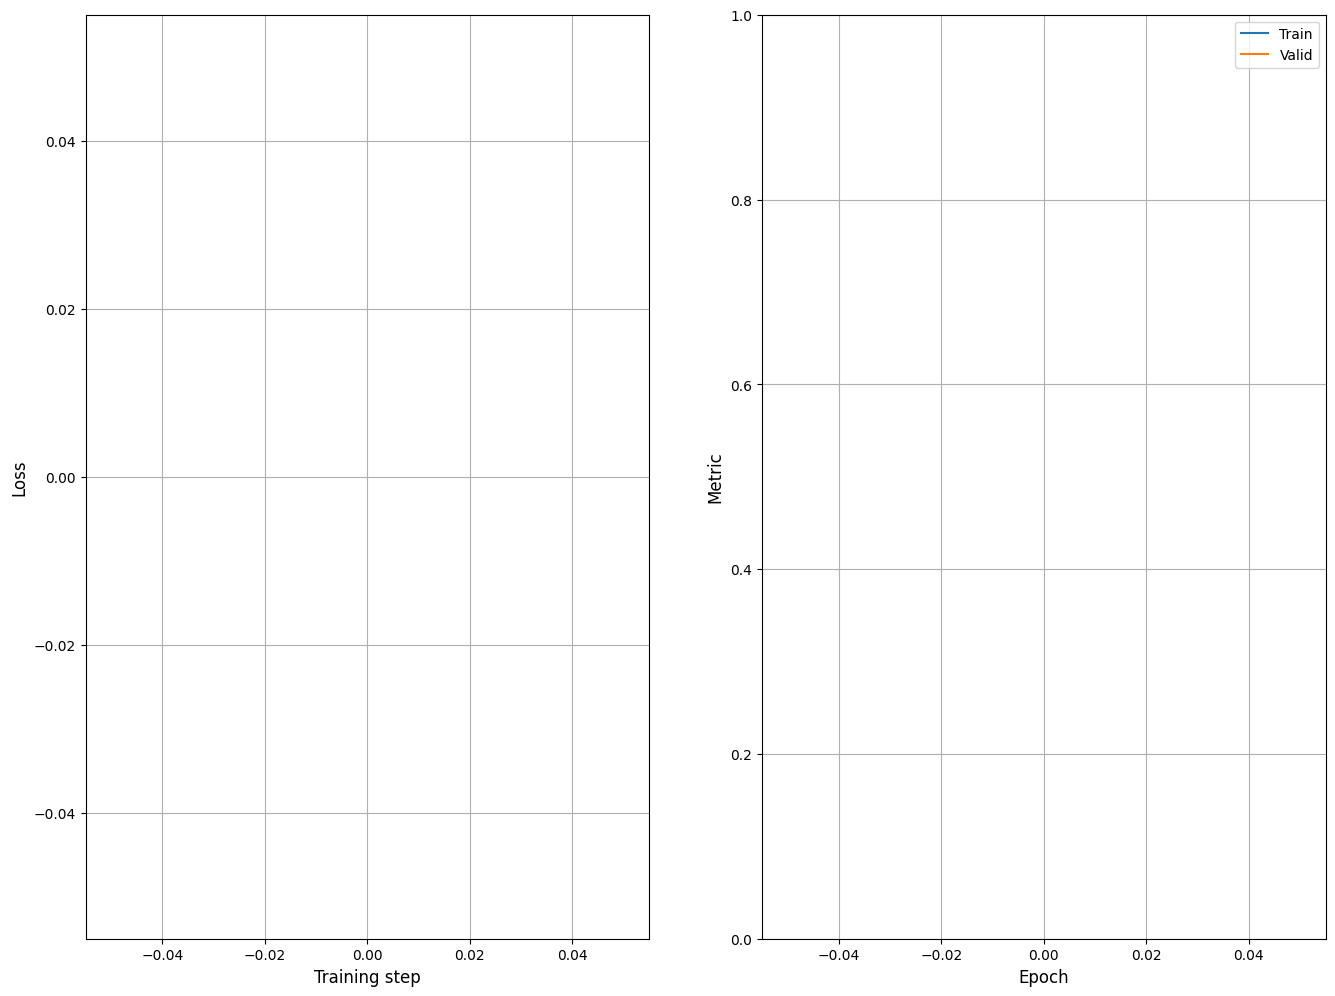

In [348]:
classifier.plot()